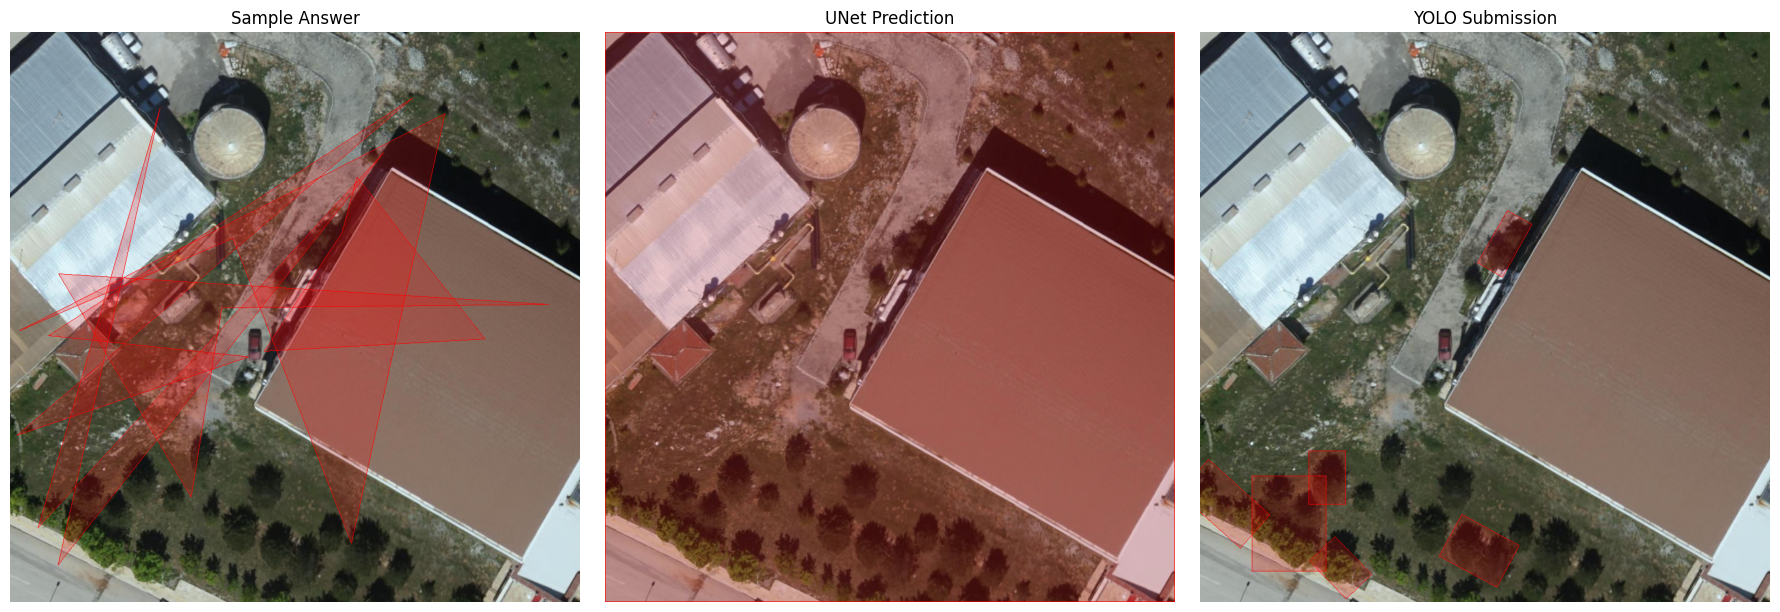

In [4]:
import json
from pathlib import Path
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# --- CONFIG ---
IMAGE_FILE = Path("data/raw/train_images/10cm_train_1.tif")
JSON_FILES = {
    "Sample Answer": Path("/data/raw/train_annotations.json"),
    "UNet Prediction": Path("data/test/evaluation_images/jsons/unet_evaluation.json"),
    "YOLO Submission": Path("data/test/evaluation_images/jsons/yolo_submission.json")
}
IMAGE_SIZE = (1024, 1024)  # Optional, will resize if needed for plotting

# --- Helper function to draw polygons ---
def draw_polygons(image, annotations, color=(255,0,0), min_confidence=0.9):
    draw = ImageDraw.Draw(image, 'RGBA')
    for ann in annotations:
        poly = ann.get("segmentation", [])
        if ann.get("confidence_score", 0) < min_confidence:
            continue  # skip low-confidence polygons
        if len(poly) >= 6:  # at least 3 points
            xy = [(poly[i], poly[i+1]) for i in range(0, len(poly), 2)]
            draw.polygon(xy, outline=color, fill=color+(50,))  # semi-transparent fill
    return image

# --- Load original image ---
orig_image = Image.open(IMAGE_FILE).convert("RGB")

# --- Plot for each JSON ---
fig, axes = plt.subplots(1, 3, figsize=(18,6))

for ax, (label, json_path) in zip(axes, JSON_FILES.items()):
    with open(json_path, 'r') as f:
        data = json.load(f)

    # Find annotations for this file
    image_entry = next((item for item in data.get("images", []) if item["file_name"] == IMAGE_FILE.name), None)
    if image_entry is None:
        print(f"{label}: No entry for {IMAGE_FILE.name}")
        image_with_poly = orig_image.copy()
    else:
        image_with_poly = orig_image.copy()
        image_with_poly = draw_polygons(image_with_poly, image_entry["annotations"], min_confidence=0.9)

    ax.imshow(image_with_poly)
    ax.set_title(label)
    ax.axis("off")

plt.tight_layout()
plt.show()


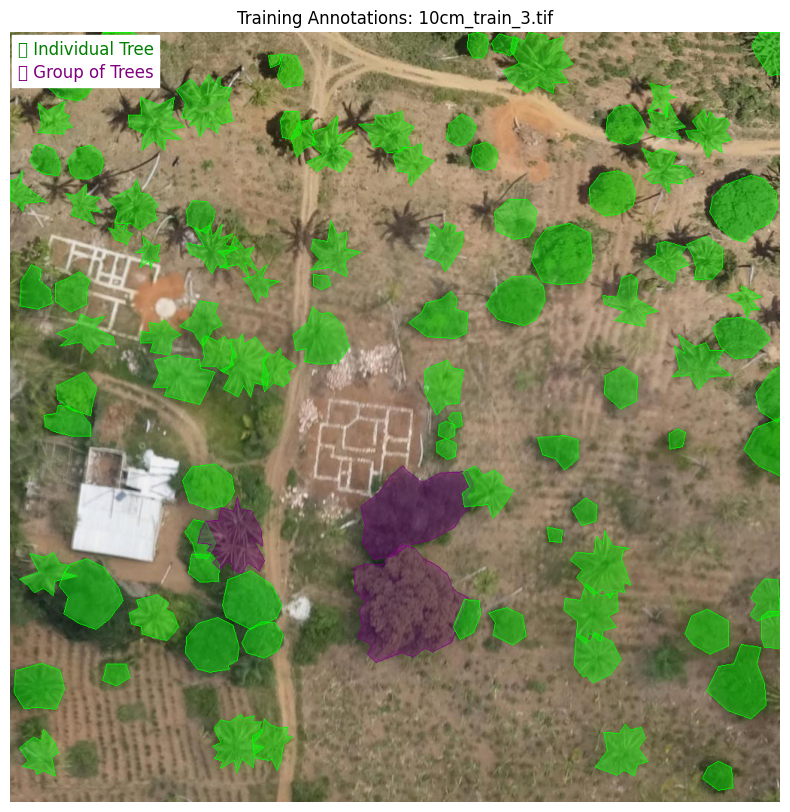

In [9]:
import json
from pathlib import Path
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# --- CONFIG ---
IMAGE_FILE = Path("data/raw/train_images/10cm_train_3.tif")
ANNOTATION_FILE = Path("data/raw/train_annotations.json")

# --- Helper function to draw polygons ---
def draw_polygons(image, annotations):
    draw = ImageDraw.Draw(image, 'RGBA')
    for ann in annotations:
        poly = ann.get("segmentation", [])
        if len(poly) < 6:
            continue

        xy = [(poly[i], poly[i + 1]) for i in range(0, len(poly), 2)]

        # color by class
        cls = ann.get("class", "").lower()
        if cls == "individual_tree":
            color = (0, 255, 0, 100)  # green
        elif cls == "group_of_trees":
            color = (128, 0, 128, 100)  # purple
        else:
            color = (255, 255, 0, 100)  # yellow fallback

        draw.polygon(xy, fill=color, outline=color[:3])
    return image

# --- Load image ---
orig_image = Image.open(IMAGE_FILE).convert("RGB")

# --- Load JSON and find annotations for this image ---
with open(ANNOTATION_FILE, 'r') as f:
    data = json.load(f)

image_entry = next((img for img in data["images"] if img["file_name"] == IMAGE_FILE.name), None)
if image_entry is None:
    raise ValueError(f"No annotations found for {IMAGE_FILE.name}")

annotations = image_entry["annotations"]

# --- Draw polygons ---
image_with_polys = draw_polygons(orig_image.copy(), annotations)

# --- Display ---
plt.figure(figsize=(10, 10))
plt.imshow(image_with_polys)
plt.title(f"Training Annotations: {IMAGE_FILE.name}")
plt.axis("off")

# Add legend manually
plt.text(10, 30, "🟩 Individual Tree", color='green', fontsize=12, backgroundcolor='white')
plt.text(10, 60, "🟪 Group of Trees", color='purple', fontsize=12, backgroundcolor='white')

plt.show()


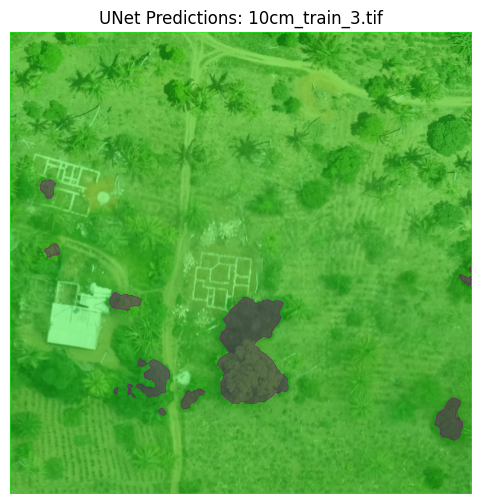

In [13]:
import json
from pathlib import Path
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# --- CONFIG ---
IMAGE_PATH = Path(r"C:\Users\hmanasi1\Documents\ADML\Project\data\raw\train_images\10cm_train_3.tif")
JSON_PATH = Path(r"C:\Users\hmanasi1\Documents\ADML\Project\data\raw\train_images\jsons\unet_train_image_predictions.json")

# --- LOAD IMAGE & JSON ---
img = Image.open(IMAGE_PATH).convert("RGB")

with open(JSON_PATH, "r") as f:
    data = json.load(f)

# --- HANDLE STRUCTURE ---
# If JSON is a single image dict (no 'images' key)
if "file_name" in data:
    image_entry = data
elif "images" in data:
    image_entry = next((x for x in data["images"] if x["file_name"] == IMAGE_PATH.name), None)
else:
    raise ValueError("Unsupported JSON structure")

if not image_entry:
    raise ValueError(f"No predictions found for {IMAGE_PATH.name}")

annotations = image_entry.get("annotations_unet", image_entry.get("annotations", []))

# --- DRAW POLYGONS ---
draw = ImageDraw.Draw(img, "RGBA")

for ann in annotations:
    seg = ann["segmentation"]
    if len(seg) >= 6:
        xy = [(seg[i], seg[i+1]) for i in range(0, len(seg), 2)]
        if ann["class"] == "individual_tree":
            color = (0, 255, 0, 100)   # green
        elif ann["class"] == "group_of_trees":
            color = (128, 0, 128, 100) # purple
        else:
            color = (255, 0, 0, 100)
        draw.polygon(xy, outline=color[:3], fill=color)

# --- SHOW RESULT ---
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.title(f"UNet Predictions: {IMAGE_PATH.name}")
plt.axis("off")
plt.show()



image 1/1 C:\Users\hmanasi1\Documents\ADML\Project\data\raw\train_images\10cm_train_3.tif: 640x640 2 group_of_treess, 13.8ms
Speed: 7.8ms preprocess, 13.8ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)


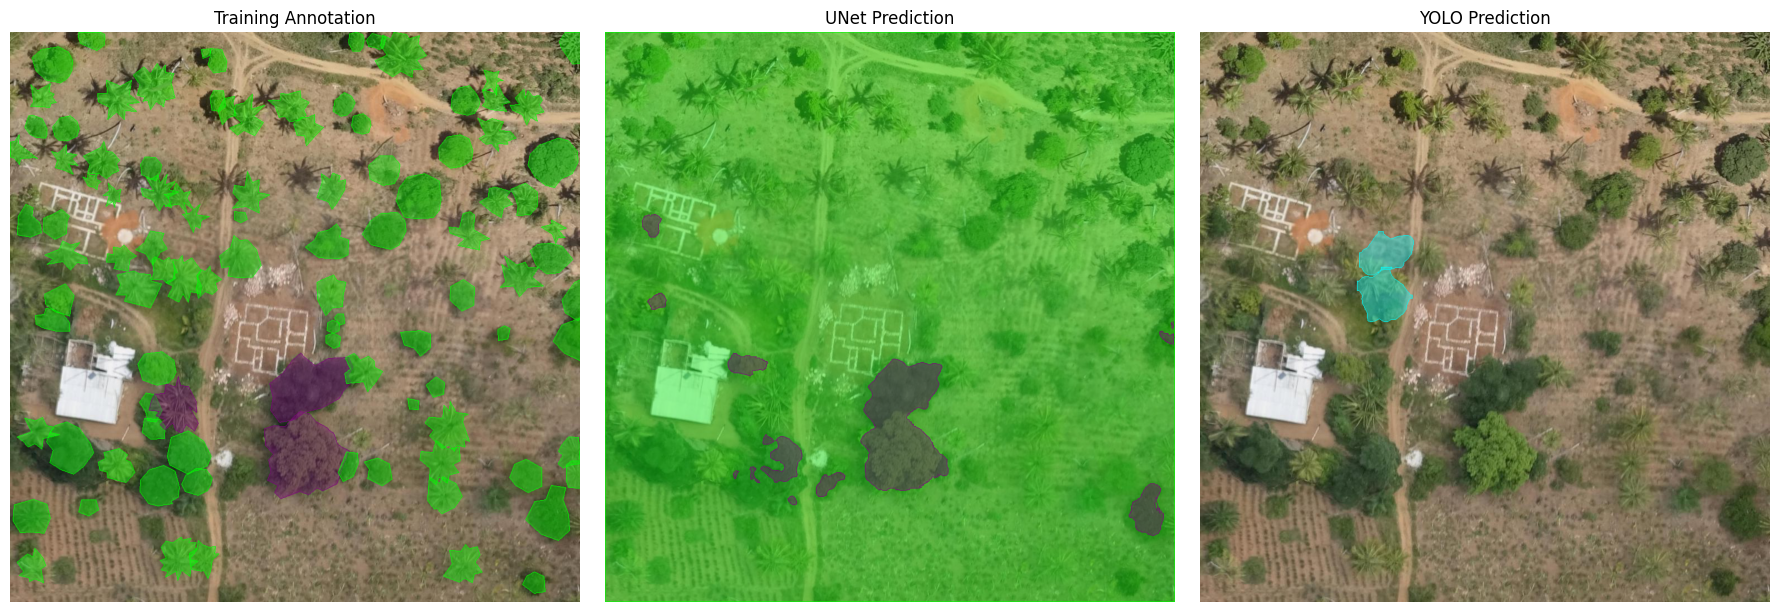

In [18]:
import json
from pathlib import Path
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon
import cv2
from ultralytics import YOLO
import torch

# --- CONFIG ---
IMAGE_PATH = Path(r"C:\Users\hmanasi1\Documents\ADML\Project\data\raw\train_images\10cm_train_3.tif")
TRAIN_JSON_PATH = Path(r"C:\Users\hmanasi1\Documents\ADML\Project\data\raw\train_annotations.json")
UNET_JSON_PATH = Path(r"C:\Users\hmanasi1\Documents\ADML\Project\data\raw\train_images\jsons\unet_train_image_predictions.json")
YOLO_MODEL_PATH = Path(r"runs/train/tree_canopy_experiment_1/weights/best.pt")
CONFIDENCE_THRESHOLD = 0.5
CLASSES = ["group_of_trees", "individual_tree"]
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ------------------------------
# Helper to draw polygons
# ------------------------------
def draw_annotations(img, annotations, class_colors, alpha=100):
    draw = ImageDraw.Draw(img, "RGBA")
    for ann in annotations:
        seg = ann["segmentation"]
        if len(seg) >= 6:
            xy = [(seg[i], seg[i+1]) for i in range(0, len(seg), 2)]
            color = class_colors.get(ann["class"], (255,0,0))
            draw.polygon(xy, outline=color[:3], fill=color+(alpha,))
    return img

# ------------------------------
# Load image
# ------------------------------
orig_img = Image.open(IMAGE_PATH).convert("RGB")
image_np = np.array(orig_img)

# ------------------------------
# Load training annotations
# ------------------------------
with open(TRAIN_JSON_PATH, "r") as f:
    train_data = json.load(f)

train_entry = next((x for x in train_data["images"] if x["file_name"] == IMAGE_PATH.name), None)
if train_entry:
    train_annotations = train_entry.get("annotations", [])
else:
    train_annotations = []

train_img = orig_img.copy()
train_img = draw_annotations(train_img, train_annotations, class_colors={
    "individual_tree": (0,255,0),
    "group_of_trees": (128,0,128)
})

# ------------------------------
# Load UNet predictions
# ------------------------------
with open(UNET_JSON_PATH, "r") as f:
    unet_data = json.load(f)

if "file_name" in unet_data:
    unet_entry = unet_data
elif "images" in unet_data:
    unet_entry = next((x for x in unet_data["images"] if x["file_name"] == IMAGE_PATH.name), None)
else:
    unet_entry = None

if unet_entry:
    unet_annotations = unet_entry.get("annotations_unet", unet_entry.get("annotations", []))
else:
    unet_annotations = []

unet_img = orig_img.copy()
unet_img = draw_annotations(unet_img, unet_annotations, class_colors={
    "individual_tree": (0,255,0),
    "group_of_trees": (128,0,128)
})

# ------------------------------
# YOLO predictions
# ------------------------------
model_yolo = YOLO(YOLO_MODEL_PATH)
results = model_yolo.predict(
    source=str(IMAGE_PATH),
    conf=CONFIDENCE_THRESHOLD,
    save=False,
    save_txt=False,
    device=DEVICE
)

yolo_annotations = []
def mask_to_polygons(mask, min_area=10):
    polygons = []
    mask_uint8 = (mask > 0.5).astype(np.uint8) * 255
    contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        if cv2.contourArea(cnt) >= min_area:
            poly = Polygon(cnt[:,0,:])
            polygons.append(poly)
    return polygons

for r in results:
    if hasattr(r, "masks") and r.masks is not None:
        masks = r.masks.data.cpu().numpy()
        class_ids = r.boxes.cls.cpu().numpy()
        for i, mask in enumerate(masks):
            class_name = CLASSES[int(class_ids[i])]
            polys = mask_to_polygons(mask)
            for poly in polys:
                coords = np.array(poly.exterior.coords).flatten().tolist()
                yolo_annotations.append({
                    "class": class_name,
                    "confidence_score": 1.0,
                    "segmentation": coords
                })

yolo_img = orig_img.copy()
yolo_img = draw_annotations(yolo_img, yolo_annotations, class_colors={
    "individual_tree": (255,255,0),
    "group_of_trees": (0,255,255)
})

# ------------------------------
# Plot side-by-side
# ------------------------------
fig, axes = plt.subplots(1,3, figsize=(18,6))
axes[0].imshow(train_img); axes[0].set_title("Training Annotation"); axes[0].axis("off")
axes[1].imshow(unet_img); axes[1].set_title("UNet Prediction"); axes[1].axis("off")
axes[2].imshow(yolo_img); axes[2].set_title("YOLO Prediction"); axes[2].axis("off")
plt.tight_layout()
plt.show()


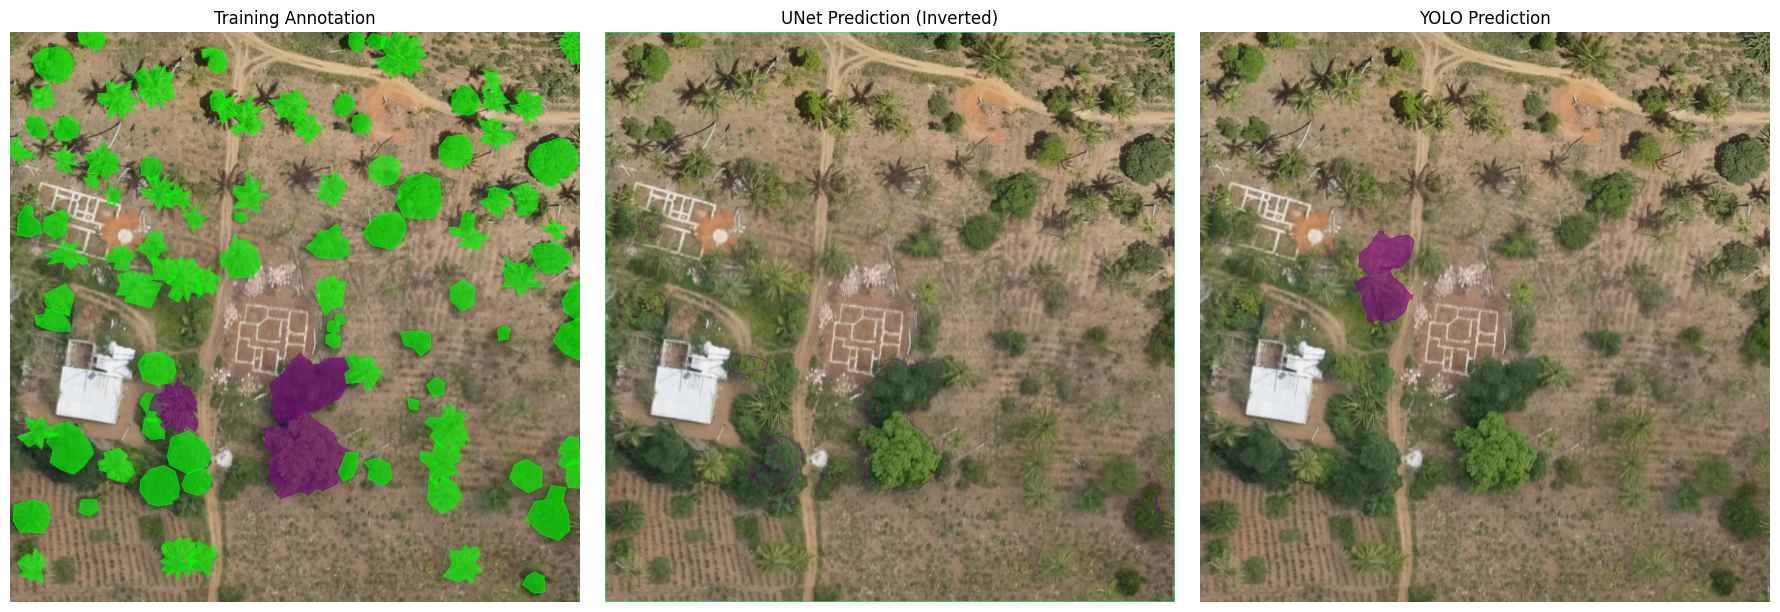

In [24]:
import json
from pathlib import Path
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# --- CONFIG ---
IMAGE_PATH = Path(r"C:\Users\hmanasi1\Documents\ADML\Project\data\raw\train_images\10cm_train_3.tif")
TRAIN_JSON_PATH = Path(r"C:\Users\hmanasi1\Documents\ADML\Project\data\raw/train_annotations.json")
UNET_JSON_PATH = Path(r"C:\Users\hmanasi1\Documents\ADML\Project\data\raw\train_images\jsons/unet_train_image_predictions.json")
YOLO_JSON_PATH = Path(r"C:\Users\hmanasi1\Documents\ADML\Project\data\raw\train_images\jsons/yolo_train_image_predictions.json")

# --- LOAD IMAGE ---
orig_img = Image.open(IMAGE_PATH).convert("RGB")

def load_annotations(json_path, key="annotations"):
    with open(json_path, "r") as f:
        data = json.load(f)
    # Handle single image dict vs list of images
    if "file_name" in data and data["file_name"] == IMAGE_PATH.name:
        return data.get(key, [])
    elif "images" in data:
        image_entry = next((x for x in data["images"] if x["file_name"] == IMAGE_PATH.name), None)
        return image_entry.get(key, []) if image_entry else []
    else:
        return []

# --- LOAD ANNOTATIONS ---
train_annotations = load_annotations(TRAIN_JSON_PATH)
unet_annotations = load_annotations(UNET_JSON_PATH, key="annotations_unet")
yolo_annotations = load_annotations(YOLO_JSON_PATH, key="annotations_yolo")

def draw_polygons(img, annotations, invert=False):
    img_copy = img.copy()
    draw = ImageDraw.Draw(img_copy, "RGBA")
    for ann in annotations:
        seg = ann["segmentation"]
        if len(seg) >= 6:
            xy = [(seg[i], seg[i+1]) for i in range(0, len(seg), 2)]
            cls_name = ann["class"]
            if invert:
                # UNet inverted: outlines only
                if cls_name == "individual_tree":
                    outline_color = (0, 255, 150)     # bright green outline
                elif cls_name == "group_of_trees":
                    outline_color = (128, 0, 128)   # purple outline
                else:
                    outline_color = (255, 0, 150)
                fill_color = (0,0,0,0)  # transparent fill
            else:
                # Filled polygons (for training / YOLO)
                if cls_name == "individual_tree":
                    outline_color = (0, 255, 0)
                    fill_color = (0, 255, 0, 150)
                elif cls_name == "group_of_trees":
                    outline_color = (128, 0, 128)
                    fill_color = (128, 0, 128, 150)
                else:
                    outline_color = (255,0,0)
                    fill_color = (255,0,0,150)

            draw.polygon(xy, outline=outline_color, fill=fill_color)
    return img_copy

# --- DRAW IMAGES ---
train_img_drawn = draw_polygons(orig_img, train_annotations)
unet_img_drawn = draw_polygons(orig_img, unet_annotations, invert=True)
yolo_img_drawn = draw_polygons(orig_img, yolo_annotations)

# --- PLOT SIDE-BY-SIDE ---
fig, axes = plt.subplots(1, 3, figsize=(18,6))

axes[0].imshow(train_img_drawn)
axes[0].set_title("Training Annotation")
axes[0].axis("off")

axes[1].imshow(unet_img_drawn)
axes[1].set_title("UNet Prediction (Inverted)")
axes[1].axis("off")

axes[2].imshow(yolo_img_drawn)
axes[2].set_title("YOLO Prediction")
axes[2].axis("off")

plt.tight_layout()
plt.show()


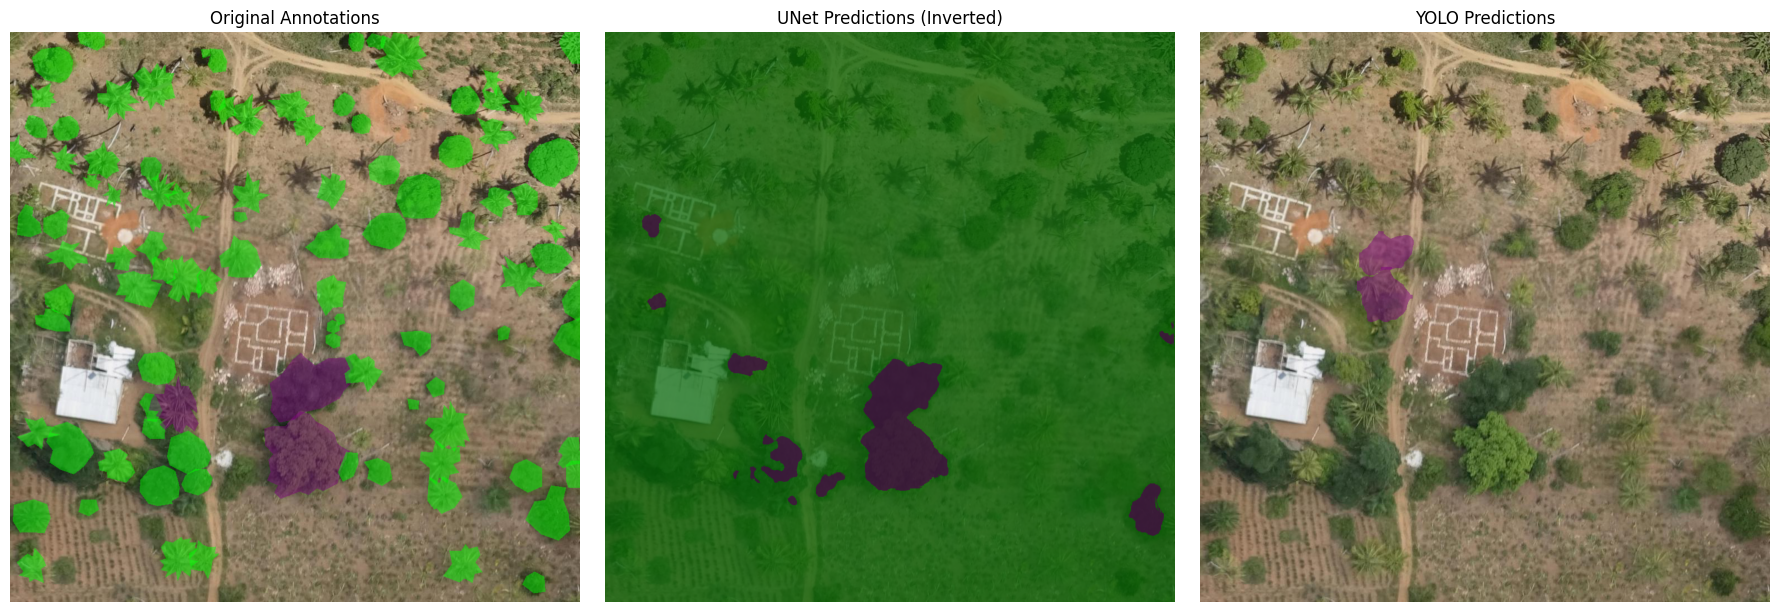

In [26]:
import json
from pathlib import Path
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# --- CONFIG ---
IMAGE_PATH = Path(r"C:\Users\hmanasi1\Documents\ADML\Project\data\raw\train_images\10cm_train_3.tif")

JSON_ORIGINAL = Path(r"C:\Users\hmanasi1\Documents\ADML\Project\data\raw\train_annotations.json")
JSON_UNET     = Path(r"C:\Users\hmanasi1\Documents\ADML\Project\data\raw\train_images\jsons\unet_train_image_predictions.json")
JSON_YOLO     = Path(r"C:\Users\hmanasi1\Documents\ADML\Project\data\raw\train_images\jsons\yolo_train_image_predictions.json")

# --- LOAD IMAGE ---
img_orig = Image.open(IMAGE_PATH).convert("RGB")

def load_annotations(json_path, image_name, key='annotations'):
    with open(json_path, 'r') as f:
        data = json.load(f)
    # Handle single image dict vs list under "images"
    if "file_name" in data and data["file_name"] == image_name:
        return data.get(key, [])
    elif "images" in data:
        entry = next((x for x in data["images"] if x["file_name"] == image_name), None)
        if entry:
            return entry.get(key, [])
    return []

# --- DRAW POLYGONS ---
def draw_annotations(base_img, annotations, inverted_unet=False):
    img = base_img.copy()
    draw = ImageDraw.Draw(img, "RGBA")
    for ann in annotations:
        seg = ann["segmentation"]
        if len(seg) >= 6:
            xy = [(seg[i], seg[i+1]) for i in range(0, len(seg), 2)]
            cls_name = ann["class"]
            if inverted_unet:  # dark fill for UNet
                if cls_name == "individual_tree":
                    fill_color = (0, 100, 0, 180)   # dark green
                elif cls_name == "group_of_trees":
                    fill_color = (75, 0, 75, 180)   # dark purple
                else:
                    fill_color = (0,0,0,180)
                draw.polygon(xy, fill=fill_color)
            else:  # Original / YOLO colors
                if cls_name == "individual_tree":
                    fill_color = (0, 255, 0, 120)   # bright green
                elif cls_name == "group_of_trees":
                    fill_color = (128, 0, 128, 120) # purple
                else:
                    fill_color = (255, 0, 0, 120)
                draw.polygon(xy, fill=fill_color)
    return img

# --- LOAD ANNOTATIONS ---
ann_orig = load_annotations(JSON_ORIGINAL, IMAGE_PATH.name)
ann_unet = load_annotations(JSON_UNET, IMAGE_PATH.name, key='annotations_unet')
ann_yolo = load_annotations(JSON_YOLO, IMAGE_PATH.name, key='annotations_yolo')

# --- DRAW IMAGES ---
img_orig_annot = draw_annotations(img_orig, ann_orig)
img_unet = draw_annotations(img_orig, ann_unet, inverted_unet=True)
img_yolo = draw_annotations(img_orig, ann_yolo)

# --- PLOT ---
fig, axes = plt.subplots(1, 3, figsize=(18,6))
axes[0].imshow(img_orig_annot); axes[0].set_title("Original Annotations"); axes[0].axis('off')
axes[1].imshow(img_unet);      axes[1].set_title("UNet Predictions (Inverted)"); axes[1].axis('off')
axes[2].imshow(img_yolo);      axes[2].set_title("YOLO Predictions"); axes[2].axis('off')

plt.tight_layout()
plt.show()
